## Smart water flooding analytical solution
This document is mostly based on the SPE-7660 paper by Gary Pope. I first implement the simple water flooding analytical solution and then expand it to low salinity water flooding with and without ionic adsorption.

## Mathematical model
The two phase flow equation in a 1D porous medium reads
$$\frac{\partial S_w}{\partial t}+\frac{u}{\varphi}\frac{df_w}{dS_w}\frac{\partial S_w}{\partial x} = 0 $$
The dimensionless time and space are defined as
$$t_D = \frac{ut}{\varphi L}$$ and
$$x_D = \frac{x}{L}$$
The velocity of a constant saturation front is calculated by
$$V_{S_w} = (\frac{dx}{dt})_{S_w}=\frac{u}{\varphi}\frac{df_w}{dS_w}$$
The shock front is specified by
$$\frac{f_w(S_{w,shock})-f_w(S_{w,init})}{S_{w,shock}-S_{w,init}}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
The injected water front velocity (i.e., a tracer in the injected water, or the low salinity of the injected brine) is calculated by
$$V_{c} = (\frac{dx}{dt})_{c}=\frac{u}{\varphi}\frac{f_w}{S_w}$$
an the water saturation that corresponds to the position of the salinity front is given by
$$\frac{f_w(S_{w,s})-f_w(0)}{S_{w}-0.0}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
which is the tangent line fron the point (0,0) to the $f_w-S_w$ (fractional flow) curve.
The breakthrough time (in number of pore volume) is calculated by
$$t_{D, bt} = \left(\frac{df_w}{dS_w}\right)^{-1}_{S_{w,shock}}$$
The other useful relation is the average saturation after breakthrough, which reads
$$S_{w,av} = S_{or}+\left[(1-f_w)\left(\frac{df_w}{dS_w}\right)\right]_{x=L}, \;t_D>t_{D,bt}$$ 
The recovery factor then can be calculated based on the fact that the recovery curve is linear until the breakthrough, and after breakthrough it gradually reaches a plateau. The oil recovery factor before the breakthrough is calculated by
$$R = \frac{(1-f_w(S_{w,init}))t_D}{1-S_{w,init}}, \;t_D<t_{D,bt}$$ and after breakthrough by
$$R = \frac{S_{w,init}-S_{w,av}}{1-S_{w,init}}, \; t_D>t_{D,bt}$$
Let's try the above formulation in Julia.

## Adsorption of polymer
The adsorption of polymer is related to the concentration of polymer in the aqueous phase $c_i$ (g/m$^3$) by
$$\hat{c}_i = D_i c_i$$
where $\hat{c}_i$ (g/m$^3$) is the concentration of adsorbed polymer per unit volume, i.e.
$$\hat{c}_i = \frac{(1-\varphi)\rho_s a_i}{\varphi}$$
where $\rho_s$ (kg/m$^3$) is the density of the rock and $a_i$ (g/m$^2$) is the concentration of adsorbed polymer per unit area.

## Energy analysis
In this notebook, we present the exergy analysis of polymer flooding compared to waterflooding by quantifying the power requirement for the injection of the water and water/polymer mixture and for the lift and processing of the produced fluids. This is an example that explains our methodology. The idea is to find out if we add polymer, which will increase the energy demand of the operation due to its higher viscosity and also the energy required for its production, but will reduce the water cut and subsequently the energy demand for the lift, separation, and water treatment.

## Using the package
The `FractionalFlow.jl` package is written based on a set of analytical solution summarized by Pope (1981) in a SPE paper. The solutions that are offered by the package are shown in the following cells:

In [5]:
# Load the module
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot # visualization with matplotlib.pyplot
FF = FractionalFlow # assign a simpler name to FractionalFlow module

Main.FractionalFlow

## Water flooding
We inject a few pore volumes of water and calculate the volume oil and water produced. We use the flow of water to calculate the processing energy and the pressure drop curve to calculate the injection pressure. We can also use the result to calculate the amount of energy for lifting. Let's have some of the numbers listed here:

In [6]:
# pumping
function pump_energy(p_out, flow_rate; eta_pump = 0.8, p_in = 1e5)
    # p_out: outlet pressure of the pump, e.g. bottomhole pressure in Pa
    # flow_rate: injection rate in m^3/s
    # eta_pump: pump mechanical efficiency
    # p_in: fluid pressure entering the pump in Pa
    return flow_rate*(p_out-p_in)
end

# Exergy values
water_treatment_exergy = 18.0 # kJ/kg produced water treatment exergy
polymer_exergy = 123600 # kJ/kg exergy of polymer production
water_softening = 50.0  # kJ/kg exergy of water softening for water injection
oil_exergy = 1e3 # kJ/kg oil exergy
oil_density = 800 # kg/m^3
water_density = 1000 # kg/m^3
water_viscosity = 0.001 # Pa.s
polymer_viscosity = 0.01 # Pa.s viscosity of water/polymer mixture (50cP (concentration of 1800 ppm))
oil_viscosity = 0.01 # Pa.s viscosity of oil
D_ads = 0.2 # adsorption parameter; see Pope for definition
w_polymer = 1800e-6 # g/g polymer mass fraction

0.0018

## Process parameter
There are other parameters that need to e defined for the simulation of a water flooding processes that can be improved later by the addition of polymer. We assume that we have an onshore reservoir of 50 m thickness and the distance between the wells is 500 m. We assume that the addition of polymer does not alter the relative permeability of oil and water in the porous medium. We only change the viscosity of the injected water witht the polymer concentration. Since the diffusion is ignored in the formulation, there is no need for a correlation for the viscosity of polymer-water solution versus the polymer concentration. One data point would suffice. The required data is shown in the following cell:

In [7]:
depth_res = 2000.0 # m reservoir depth
g = 9.8 # m/s² acceleration due to gravity
L_res = 500.0 # m well spacing
w_res = 50. # m reservoir thickness
ϕ = 0.2 # porosity
k = 0.1e-12 # m² permeability
krw0 = 0.2
kro0 = 0.9
swc = 0.15
sor = 0.35
nw = 4.0
no = 2.0
u_inj = 0.1/(3600*24) # m/day injection velocity
D_well = 5*2.54*1e-2 # 5" well diameter converted to m
Q_inj = u_inj*π*D_well^2/4*w_res # m³/s injection rate
pv_inject=2.0 # number of pore volumes injected
p_producer = water_density*g*depth_res # Pa hydrostatic pressure
sw_init=0.2 # initial water saturation of the reservoir
sw_inj=1.0  # injection saturation

1.0

In [8]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=krw0, kro0=kro0, 
    swc=swc, sor=sor, nw=nw, no = no)
# define the fluids
fluids_wf = FF.oil_water_fluids(mu_water=water_viscosity, mu_oil=oil_viscosity)
fluids_pf = FF.oil_water_fluids(mu_water=polymer_viscosity, mu_oil=oil_viscosity)
# define the flooding
core_flood = FF.core_flooding(u_inj=u_inj, pv_inject=pv_inject, 
    p_back=p_producer, sw_init=sw_init, sw_inj=sw_inj, rel_perms=rel_perms)
# define the reservoir
core_props = FF.core_properties(L=L_res, φ=ϕ, k=k)
# FF.visualize(rel_perms)

Main.FractionalFlow.CoreProperties(500.0, 0.03, 0.2, 1.0e-13, 2000.0, 2700.0)

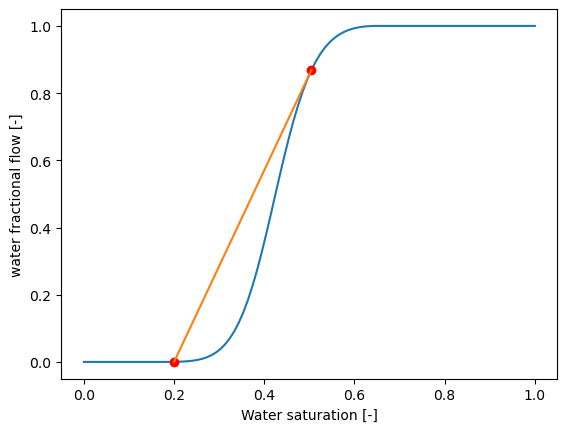

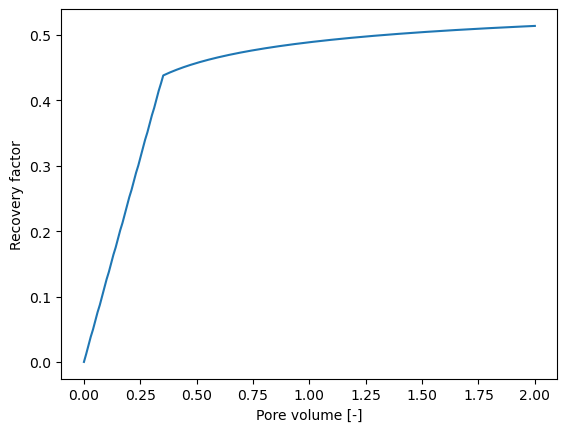

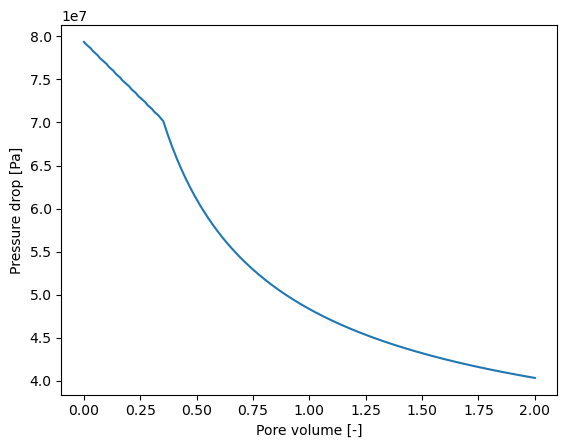

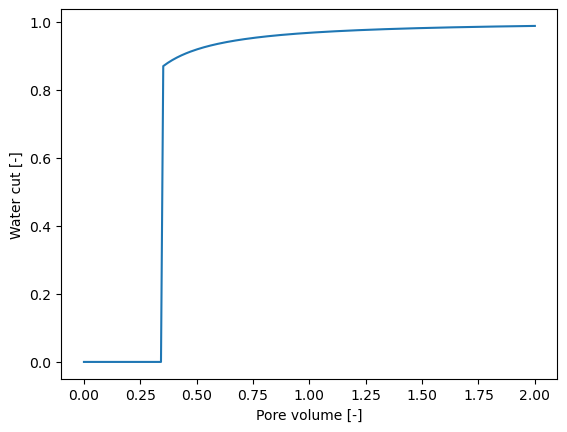

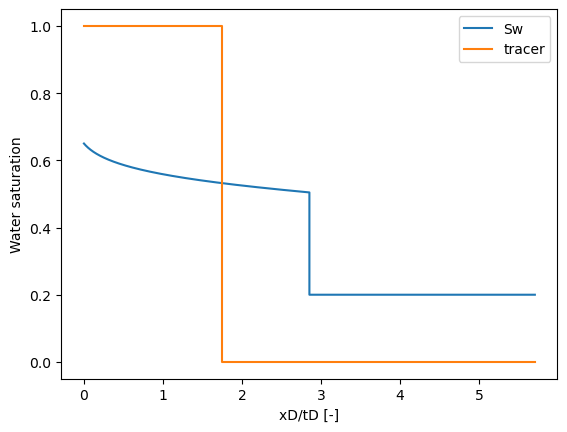

PyObject <matplotlib.legend.Legend object at 0x00000000562FCC40>

In [9]:
wf_res = FF.water_flood(core_props, fluids_wf, rel_perms, core_flood)
# fw, dfw = FF.fractional_flow_function(rel_perms, fluids_wf)
# sw_tmp = range(0, 1, length=100)
# plot(sw_tmp, fw.(sw_tmp), xlabel = "Sw", ylabel="fw", label="")
# plot!(sw_tmp, dfw.(sw_tmp))
# figure(1)
# plot(pv, R) 
# xlabel("PV injected")
# ylabel("Recovery factor") 
# title("Water flooding")
# figure(2)
# plot(xt, sw)
# xlabel("x/t [-]")
# ylabel("Water saturation [-]")
FF.visualize(wf_res)

In [104]:
# FF.print_relperm(rel_perms, title="Corey rel-perm parameters")
# define the fractional flow functions
# fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()

## Polymer fooding
Here, I use my low salinity code (which is based on the polymer flooding code) and solve a polymer flooding model including adsorption:

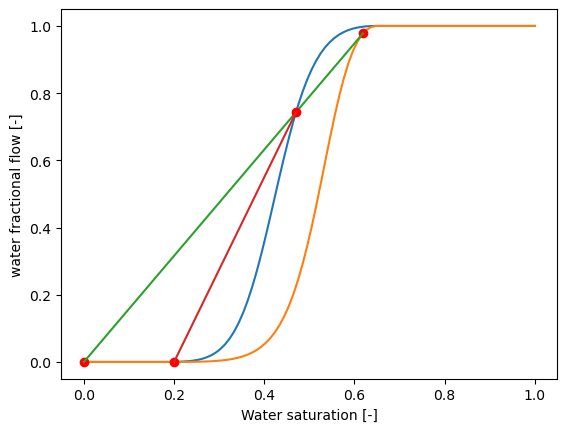

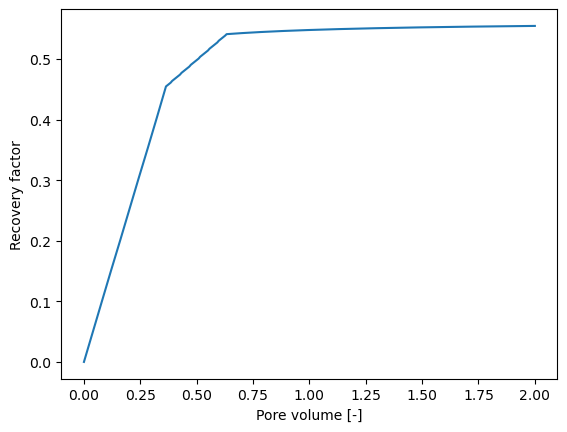

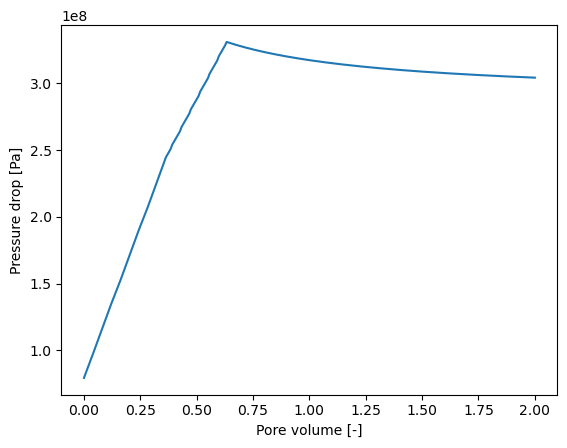

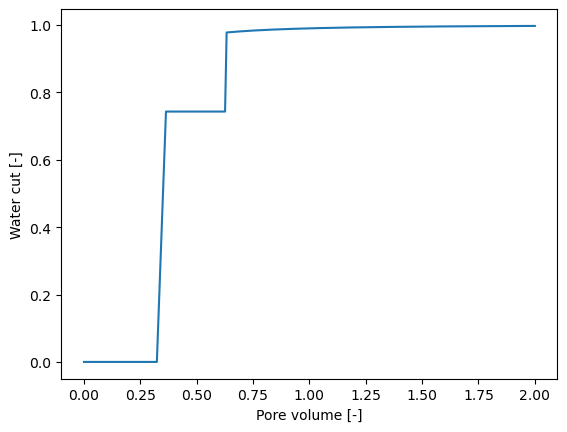

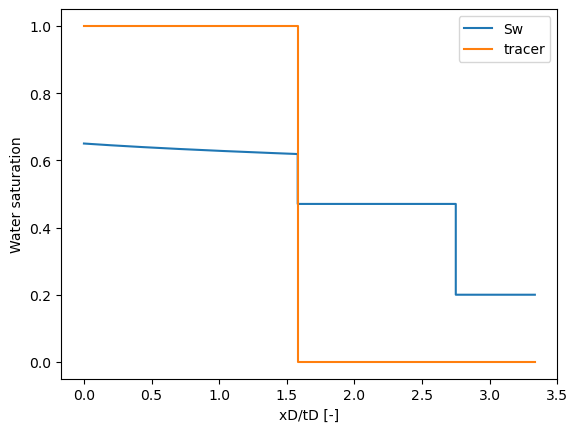

PyObject <matplotlib.legend.Legend object at 0x0000000061A89F10>

In [10]:
pf_res = FF.single_ion_adsorption_water_flood(core_props, fluids_pf, fluids_wf, rel_perms, 
        rel_perms, core_flood, 0.0)
FF.visualize(pf_res)

## Compare with numeric

In [11]:
t_sec, pv_num, rec_fact, xt_num, sw_num, c_old, c_out_sal, wc = 
    FF.polymer_implicit_upwind(core_props, fluids_pf, fluids_wf, rel_perms, 
        rel_perms, core_flood);

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:02m39mmm39mm9mm9mmmm39mmm

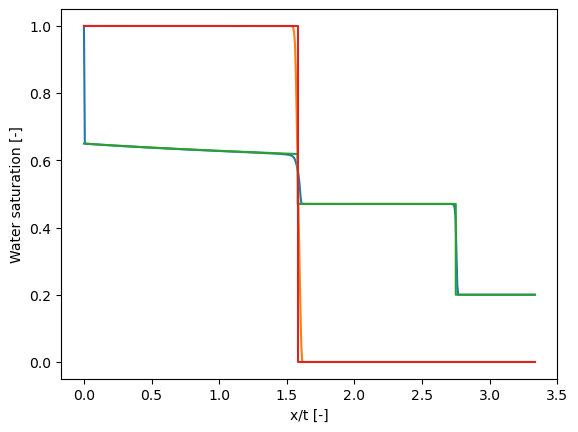

PyObject Text(24.000000000000007, 0.5, 'Water saturation [-]')

In [12]:
figure(2)
plot(xt_num/(core_props.length)/pv_num[end], sw_num)
plot(xt_num/(core_props.length)/pv_num[end], 1.0.-c_old)
plot(pf_res.saturation_profile_xt[:,1], pf_res.saturation_profile_xt[:,2])
plot(pf_res.tracer_profile_xt[:,1], pf_res.tracer_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")

## Plot the water cut

## Run the numerical code for 2 PV

In [13]:
t_sec2, pv_num2, rec_fact2, xt_num2, sw_num2, c_old2, c_out_sal2, wc2 = 
    FF.polymer_implicit_upwind(core_props, fluids_pf, fluids_wf, rel_perms, 
        rel_perms, core_flood, pv_inj=2.0);

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:07

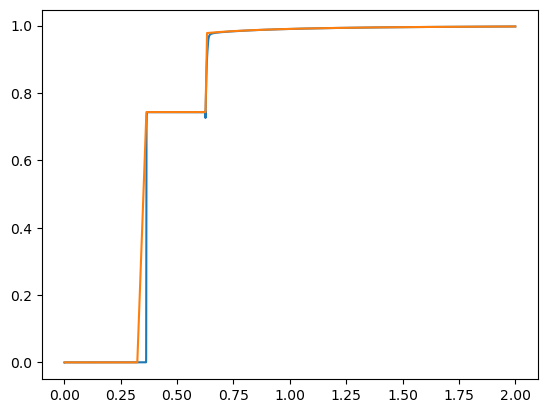

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000016A6460>

In [14]:
figure(4)
plot(pv_num2, wc2)
plot(pf_res.water_cut_pv[:,1], pf_res.water_cut_pv[:,2])

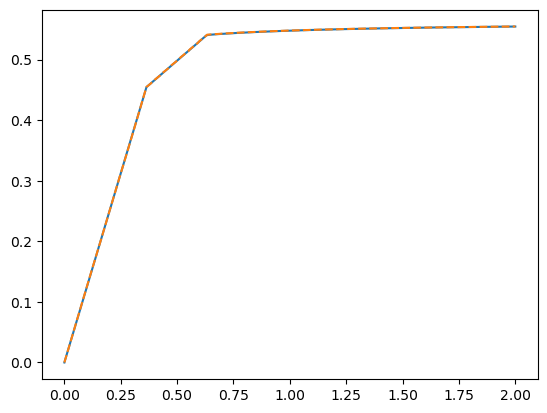

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001A28160>

In [15]:
figure(5)
plot(pv_num2, rec_fact2)
plot(pf_res.recovery_pv[:,1], pf_res.recovery_pv[:,2], "--")

# Energy analysis
In this section, we calculate the energy requirement for water flooding and then compare it with the energy requirement of polymer flooding. We then compare the CO$_2$ emission of each process per barrel of oil produced.

## Compare the recovery factors and pressure drops

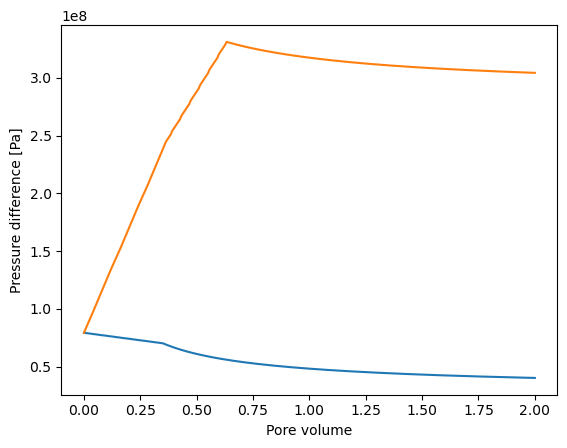

PyObject Text(24.000000000000014, 0.5, 'Pressure difference [Pa]')

In [16]:
plot(wf_res.dp_pv[:,1], wf_res.dp_pv[:,2])
plot(pf_res.dp_pv[:,1], pf_res.dp_pv[:,2])
xlabel("Pore volume")
ylabel("Pressure difference [Pa]")

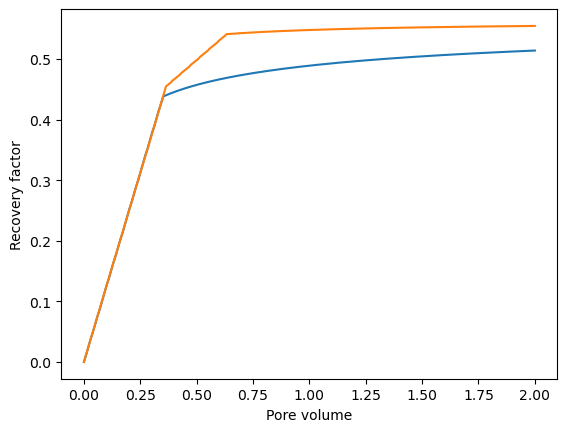

PyObject Text(24.000000000000007, 0.5, 'Recovery factor')

In [17]:
plot(wf_res.recovery_pv[:,1], wf_res.recovery_pv[:,2])
plot(pf_res.recovery_pv[:,1], pf_res.recovery_pv[:,2])
xlabel("Pore volume")
ylabel("Recovery factor")

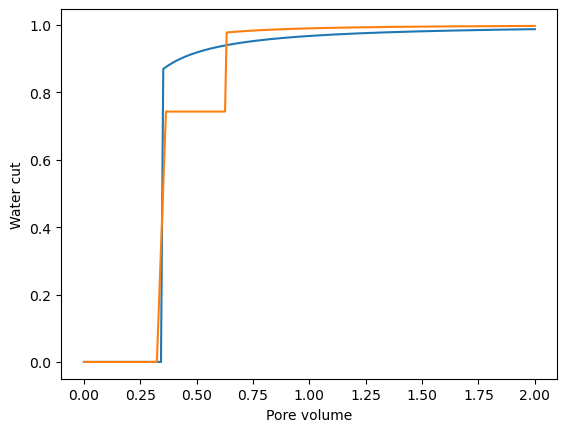

PyObject Text(24.000000000000007, 0.5, 'Water cut')

In [18]:
plot(wf_res.water_cut_pv[:,1], wf_res.water_cut_pv[:,2])
plot(pf_res.water_cut_pv[:,1], pf_res.water_cut_pv[:,2])
xlabel("Pore volume")
ylabel("Water cut")